# Cancer Regression Prediction Model.

The aim of this notebook is to develop a model that can predict the `death rates` due to cancer. You can get the data from [Kaggle](https://www.kaggle.com/datasets/varunraskar/cancer-regression/data).


# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.pipeline  import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, RFECV, f_regression

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error

# show all columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# set the default for the plot
sns.set_style('whitegrid')
sns.set_palette('colorblind')

import warnings
warnings.filterwarnings('ignore')

# 2. Import the dataset(s)

In [3]:
cancer = pd.read_csv('datasets/cancerregression/cancer_reg.csv')
cancer.head()



,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [4]:
demographics = pd.read_csv('datasets/CancerRegression/avg-household-size.csv')
demographics.head()

,statefips,countyfips,avghouseholdsize,geography
0,2,13,2.43,"Aleutians East Borough, Alaska"
1,2,16,3.59,"Aleutians West Census Area, Alaska"
2,2,20,2.77,"Anchorage Municipality, Alaska"
3,2,50,3.86,"Bethel Census Area, Alaska"
4,2,60,2.50,"Bristol Bay Borough, Alaska"


In [5]:
cancer.shape , demographics.shape

((3047, 33), (3220, 4))

The number of rows for the two datasets are inconsistent. For the purpose of this notebook, please allow me to ignore the *demographics dataset* and focus solely on the *cancer regression* dataset.

In [6]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avganncount              3047 non-null   float64
 1   avgdeathsperyear         3047 non-null   int64  
 2   target_deathrate         3047 non-null   float64
 3   incidencerate            3047 non-null   float64
 4   medincome                3047 non-null   int64  
 5   popest2015               3047 non-null   int64  
 6   povertypercent           3047 non-null   float64
 7   studypercap              3047 non-null   float64
 8   binnedinc                3047 non-null   object 
 9   medianage                3047 non-null   float64
 10  medianagemale            3047 non-null   float64
 11  medianagefemale          3047 non-null   float64
 12  geography                3047 non-null   object 
 13  percentmarried           3047 non-null   float64
 14  pctnohs18_24            

It's obvious that some of these columns have missing data. For the `pctsomecol18_24` column, it has only **762** non-null values, thus I will drop it from the dataset. For the rest of the columns, I will simply use the median value to replace missing values.

There are two *categorical columns*, `geography` and `binnedinc` columns. The rest are numerical.

In [7]:
cancer.isnull().sum()

avganncount                   0
avgdeathsperyear              0
target_deathrate              0
incidencerate                 0
medincome                     0
popest2015                    0
povertypercent                0
studypercap                   0
binnedinc                     0
medianage                     0
medianagemale                 0
medianagefemale               0
geography                     0
percentmarried                0
pctnohs18_24                  0
pcths18_24                    0
pctsomecol18_24            2285
pctbachdeg18_24               0
pcths25_over                  0
pctbachdeg25_over             0
pctemployed16_over          152
pctunemployed16_over          0
pctprivatecoverage            0
pctprivatecoveragealone     609
pctempprivcoverage            0
pctpubliccoverage             0
pctpubliccoveragealone        0
pctwhite                      0
pctblack                      0
pctasian                      0
pctotherrace                  0
pctmarri

In [ ]:
# check for duplicates
cancer.duplicated().sum()

0

The dataset has no duplicates.

In [8]:
cancer.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
avganncount,3047.0,NaN,NaN,NaN,606.338544,1416.356223,6.0,76.0,171.0,518.0,38150.0
avgdeathsperyear,3047.0,NaN,NaN,NaN,185.965868,504.134286,3.0,28.0,61.0,149.0,14010.0
target_deathrate,3047.0,NaN,NaN,NaN,178.664063,27.751511,59.7,161.2,178.1,195.2,362.8
incidencerate,3047.0,NaN,NaN,NaN,448.268586,54.560733,201.3,420.3,453.549422,480.85,1206.9
medincome,3047.0,NaN,NaN,NaN,47063.281917,12040.090836,22640.0,38882.5,45207.0,52492.0,125635.0
popest2015,3047.0,NaN,NaN,NaN,102637.370528,329059.220504,827.0,11684.0,26643.0,68671.0,10170292.0
povertypercent,3047.0,NaN,NaN,NaN,16.878175,6.409087,3.2,12.15,15.9,20.4,47.4
studypercap,3047.0,NaN,NaN,NaN,155.399415,529.628366,0.0,0.0,0.0,83.650776,9762.308998
binnedinc,3047,10,"(45201, 48021.6]",306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medianage,3047.0,NaN,NaN,NaN,45.272333,45.30448,22.3,37.7,41.0,44.0,624.0


All the entries in the `geography` dataset are unique, thus I will drop this column.

Some of the numerical columns seem to have outliers. This will be handled in the data cleaning part.

# Exploratory Data analysis.

## (i) Numerical columns

array([[<Axes: title={'center': 'avganncount'}>,
        <Axes: title={'center': 'avgdeathsperyear'}>,
        <Axes: title={'center': 'target_deathrate'}>,
        <Axes: title={'center': 'incidencerate'}>,
        <Axes: title={'center': 'medincome'}>,
        <Axes: title={'center': 'popest2015'}>],
       [<Axes: title={'center': 'povertypercent'}>,
        <Axes: title={'center': 'studypercap'}>,
        <Axes: title={'center': 'medianage'}>,
        <Axes: title={'center': 'medianagemale'}>,
        <Axes: title={'center': 'medianagefemale'}>,
        <Axes: title={'center': 'percentmarried'}>],
       [<Axes: title={'center': 'pctnohs18_24'}>,
        <Axes: title={'center': 'pcths18_24'}>,
        <Axes: title={'center': 'pctsomecol18_24'}>,
        <Axes: title={'center': 'pctbachdeg18_24'}>,
        <Axes: title={'center': 'pcths25_over'}>,
        <Axes: title={'center': 'pctbachdeg25_over'}>],
       [<Axes: title={'center': 'pctemployed16_over'}>,
        <Axes: title={'ce

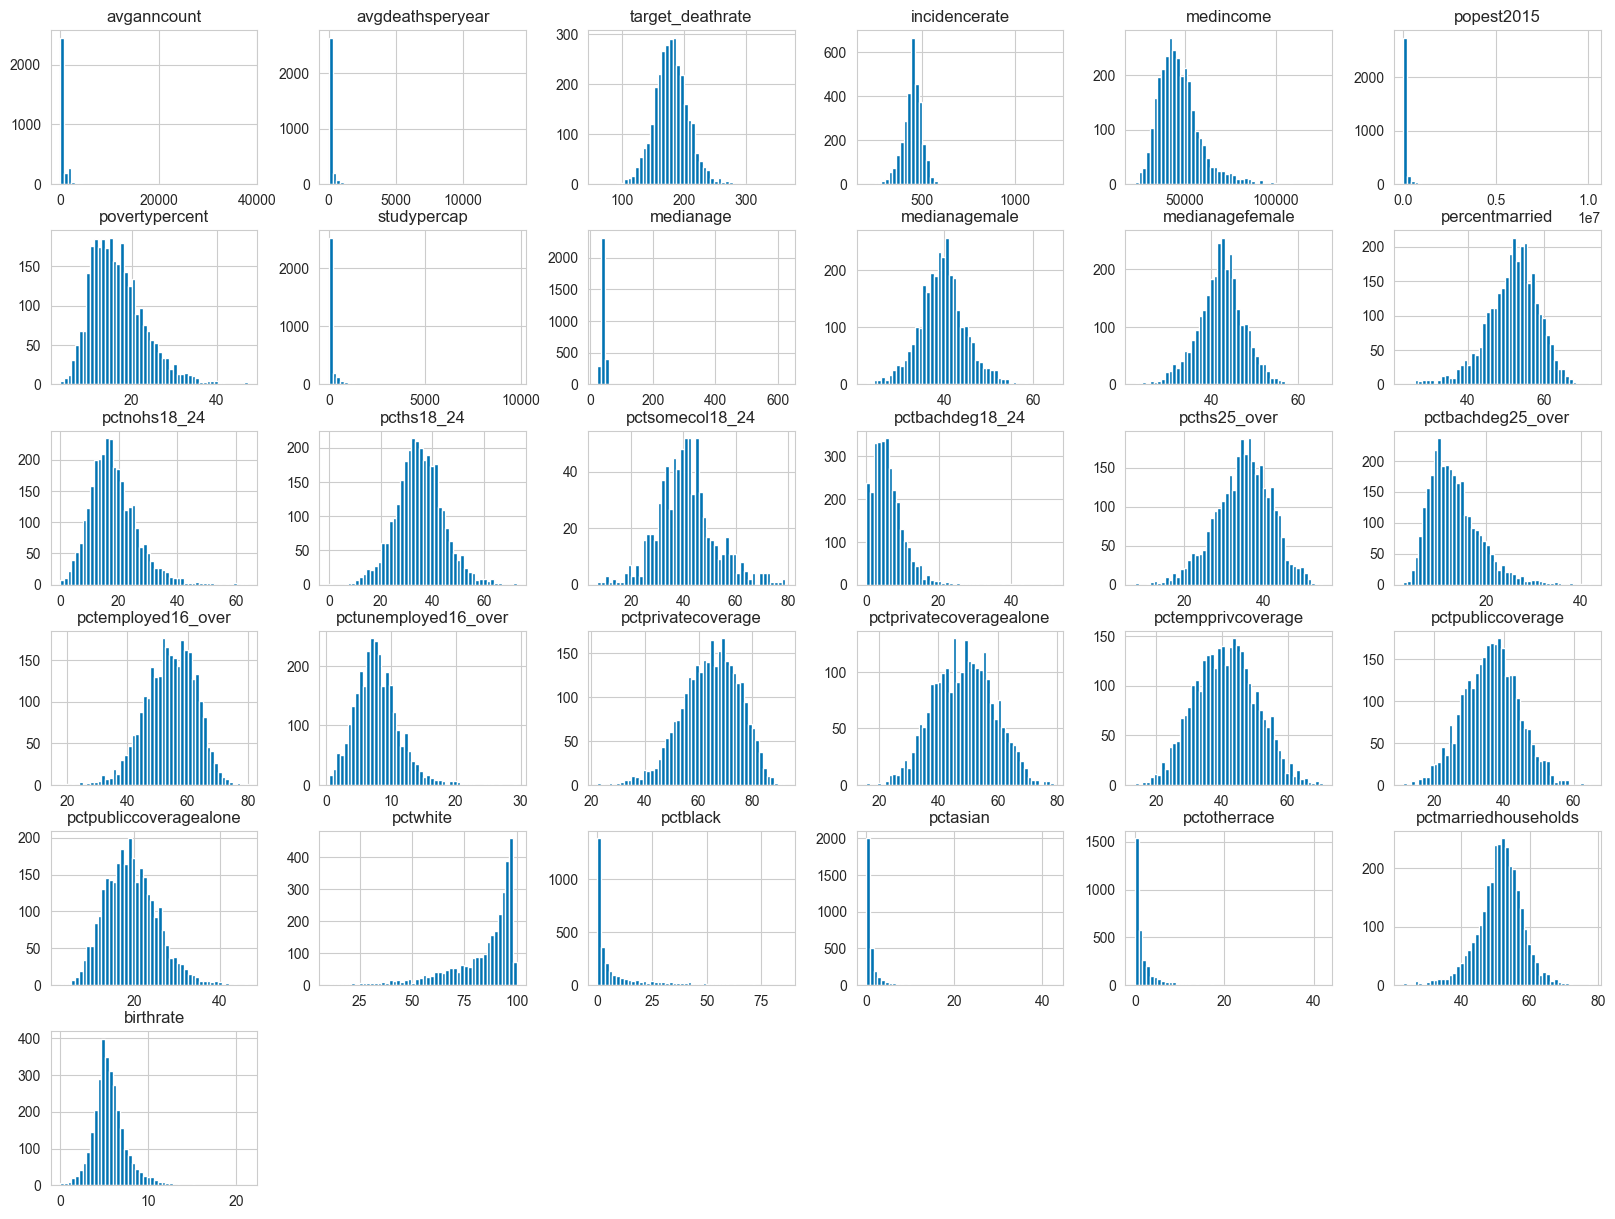

In [9]:
# histograms of the numerical columns
cancer.hist(figsize=(20, 15), bins=50)

I noted the following from the visualization above:
1. The following columns seem to have extreme outliers (`avganncount, avgdeathsperyear, popest2015, studypercap, medianage,pctblack, pctasian, pctotherrace`)
2. Use of different scales - call need for standardizing the data.

avganncount: Average number of cancer cases diagnosed annually.

avgdeathsperyear: Average number of deaths due to cancer per year.

popest2015: Estimated population in 2015.

studypercap: Per capita number of cancer-related clinical trials conducted.

pctblack: Percentage of Black population.

pctasian: Percentage of Asian population.

pctotherrace: Percentage of population belonging to other races.


I will only handle the outliers in `medainage` column for a start.

<Axes: ylabel='medianage'>

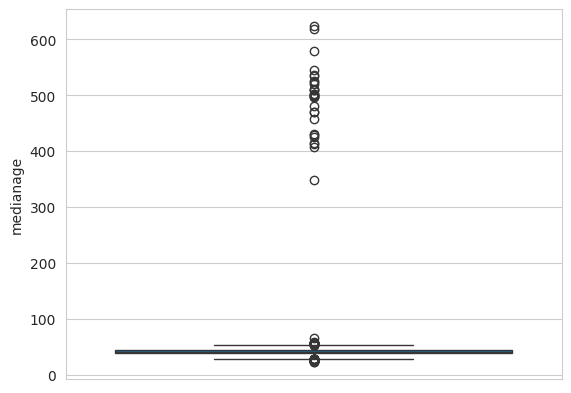

In [ ]:
# show the boxplot for the median age column
sns.boxplot(cancer['medianage'])

In [ ]:
# show the rows whose median age is greater than 100
print(len(cancer[cancer['medianage'] > 100]))

30


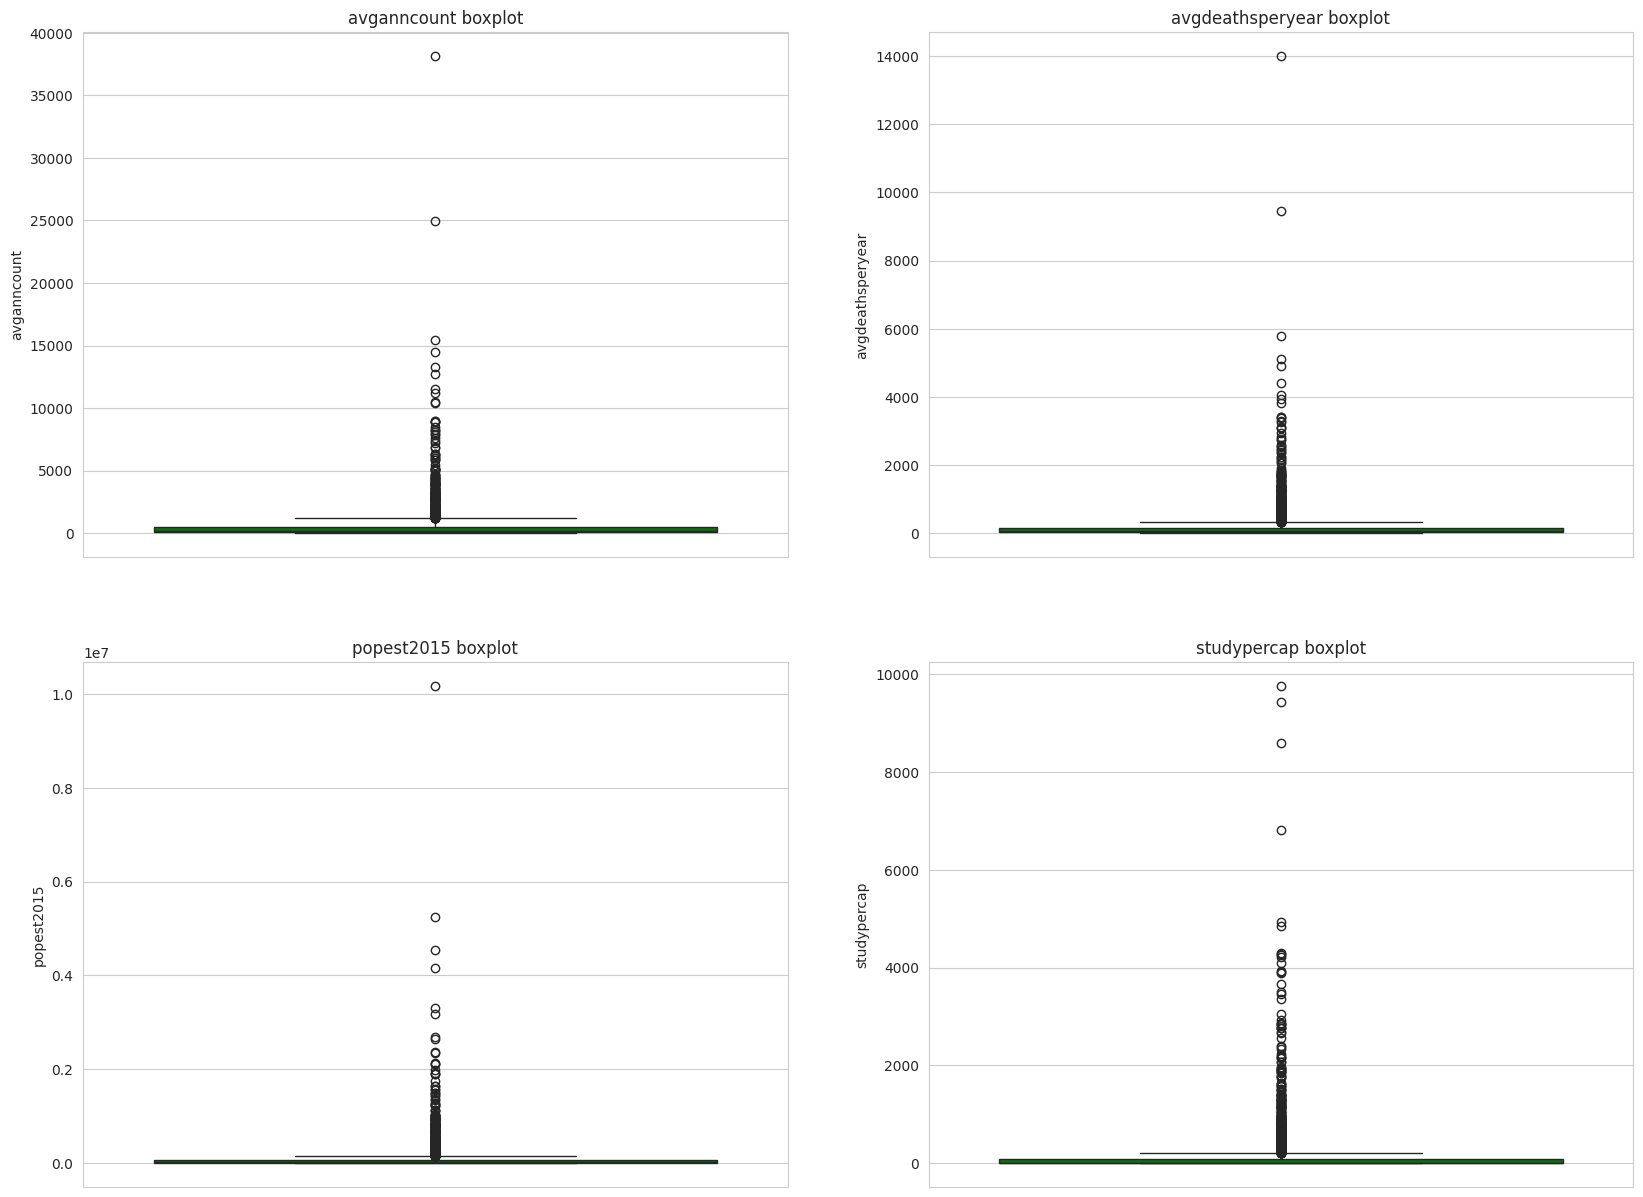

In [ ]:
# investigating outliers in the rest of the noted columns
columns = ['avganncount', 'avgdeathsperyear','popest2015','studypercap']

fig, axes = plt.subplots(nrows=2, ncols =2, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(cancer[col], color='g', ax=axes[i])
    axes[i].set_title(f'{col} boxplot')
    axes[i].set_xlabel('')


The following values will be used as the maximum values in an effort to handle the outliers:
* `medianage`: 100
* `avganncount`: 15000
* `avgdeathsperyear`: 6000
* `popest20151`: 4,000,000.

Values above the specified caps will be dropped.


## (ii) Target column

MAXIMUM VALUE 362.8, MINIMUM VALUE 59.7, MEAN 178.66406301279943


<Axes: xlabel='target_deathrate', ylabel='Count'>

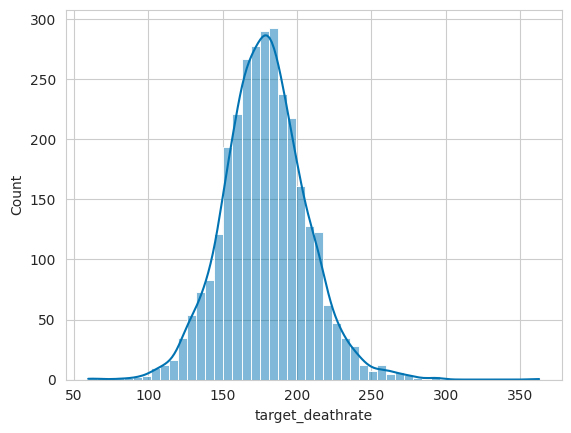

In [ ]:
print(f"MAXIMUM VALUE {cancer['target_deathrate'].max()}, MINIMUM VALUE {cancer['target_deathrate'].min()}, MEAN {cancer['target_deathrate'].mean()}")
sns.histplot(cancer['target_deathrate'], bins=50, kde=True)

<Axes: ylabel='target_deathrate'>

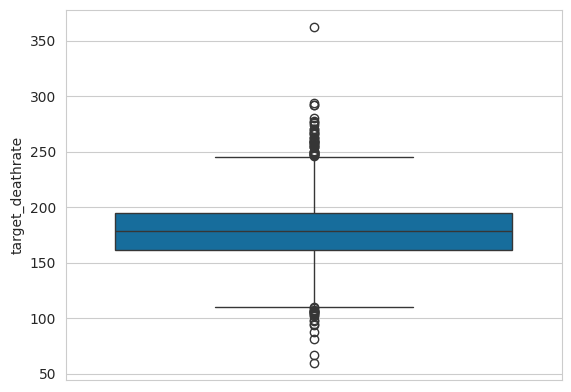

In [ ]:
sns.boxplot(cancer['target_deathrate'])

## (iii) Categorical Column(s)

In [ ]:
cancer['binnedinc'].value_counts()

,count
binnedinc,
"(45201, 48021.6]",306
"[22640, 34218.1]",306
"(54545.6, 61494.5]",306
"(48021.6, 51046.4]",305
"(51046.4, 54545.6]",305
"(42724.4, 45201]",305
"(40362.7, 42724.4]",304
"(37413.8, 40362.7]",304
"(34218.1, 37413.8]",304


The numerical values will be extracted and the mean calculated. This will convert the data into a numerical column too. The values also seem to be intentional and not random, given the almost balanced value count for each unique category.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '(61494.5, 125635]'),
  Text(1, 0, '(48021.6, 51046.4]'),
  Text(2, 0, '(42724.4, 45201]'),
  Text(3, 0, '(51046.4, 54545.6]'),
  Text(4, 0, '(37413.8, 40362.7]'),
  Text(5, 0, '(40362.7, 42724.4]'),
  Text(6, 0, '(54545.6, 61494.5]'),
  Text(7, 0, '(34218.1, 37413.8]'),
  Text(8, 0, '[22640, 34218.1]'),
  Text(9, 0, '(45201, 48021.6]')])

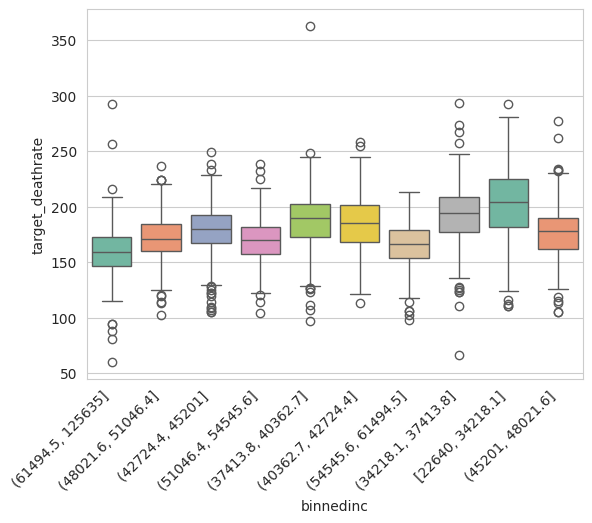

In [ ]:
sns.boxplot(data=cancer, x='binnedinc', y='target_deathrate', palette='Set2')
plt.xticks(rotation =  45, horizontalalignment='right')

## (iv) Multi-variate relationships

<Axes: >

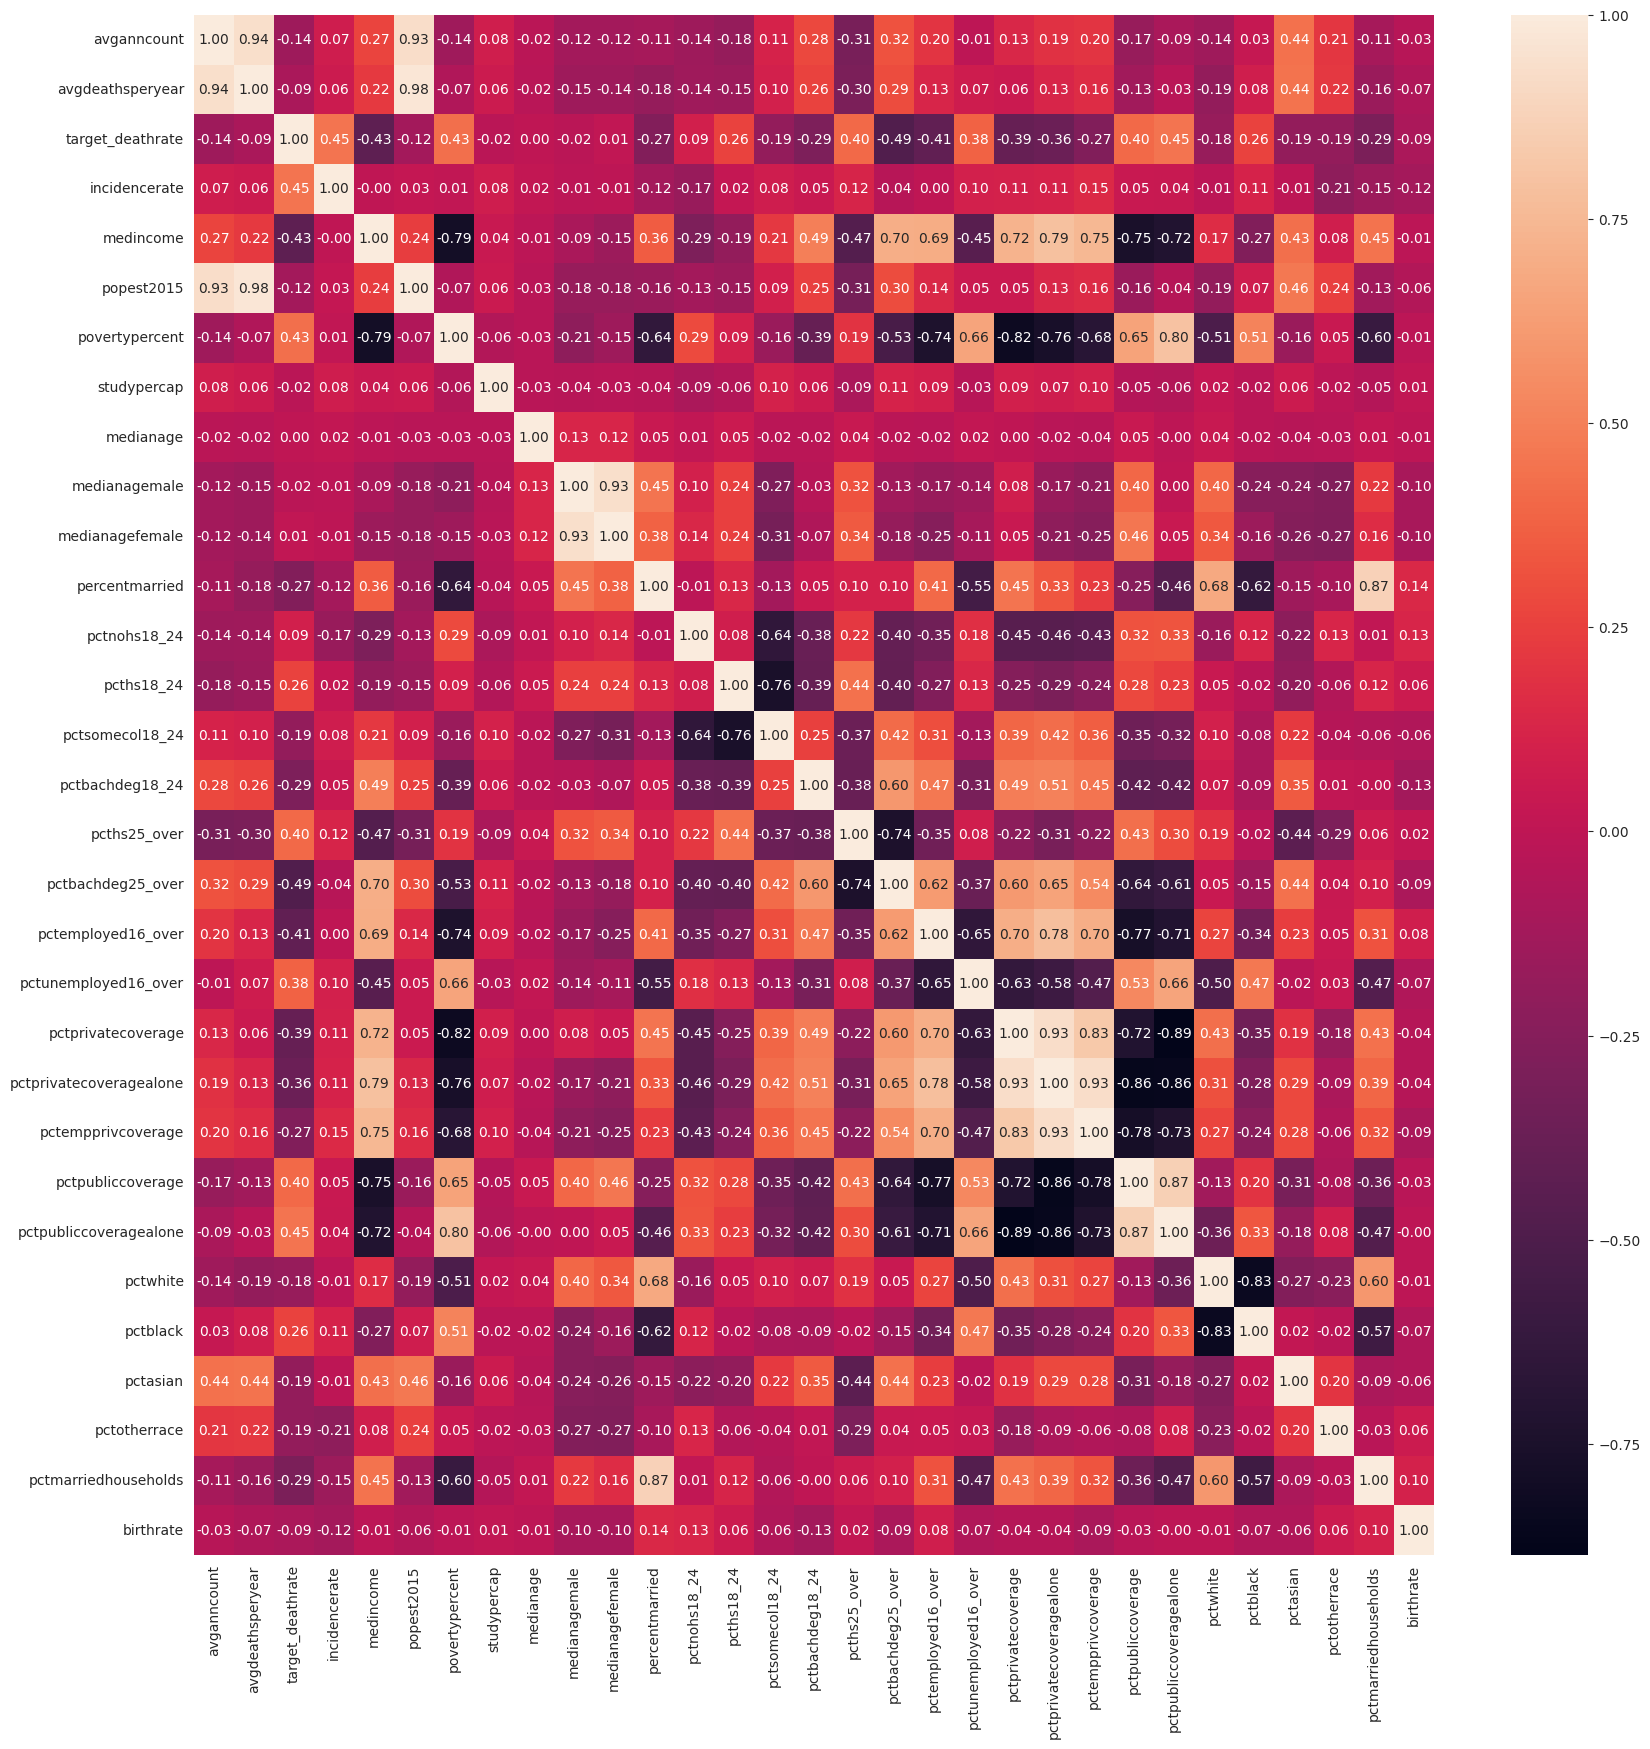

In [ ]:
# check for correlation
visuals_data = cancer.copy()
# numerical columns only
visuals_data = visuals_data.select_dtypes(include='number')

corr_matrix = visuals_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')


# 3. Splitting the data into train and test splits

To ensure that the test data is representative of the train data, I shall use the `StratifiedShuffleSplit`



deathrate_category
medium    2425
high       614
low          8
Name: count, dtype: int64


<Axes: xlabel='deathrate_category'>

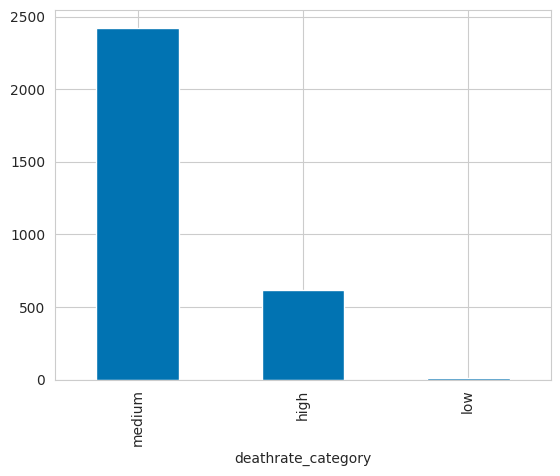

In [ ]:
cancer['deathrate_category'] = pd.cut(cancer['target_deathrate'], bins=[0, 100, 200, np.inf], labels = ['low', 'medium', 'high'])
print(cancer['deathrate_category'].value_counts())
cancer['deathrate_category'].value_counts().plot(kind='bar')

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state=42)

for train_index, test_index in split.split(cancer, cancer['deathrate_category']):
    train_set = cancer.loc[train_index]
    test_set = cancer.loc[test_index]

train_set.drop('deathrate_category', axis=1, inplace=True)
test_set.drop('deathrate_category', axis=1, inplace=True)
cancer.drop('deathrate_category', axis=1, inplace=True)

# 4. Data Cleaning

In [ ]:

def clean_data(data):
    '''
    This function performs the following operations on the dataset provides:
    1. Drops the 'geography and pctsomecol18_24' columns
    2. Handles outliers by replacing rows with median age greater than 100, avganncount > 15000, avgdeathsperyear > 6000, popest2015 > 4,000,000 and studypercap > 6000 with the mean of the respective columns
    3. Replaces missing values with the median of the respective columns
    4. Extracts the numerical values in 'binnedinc' column and replaces it with the median value
    5. Standardizes the numerical columns
    5. Returns the cleaned dataset

    '''

    data.drop(['geography', 'pctsomecol18_24'], axis=1, inplace=True)

    # replace outliers with the median of the respective columns
    data['medianage'] = data['medianage'].apply(lambda x: data['medianage'].median() if x > 100 else x)
    data['avganncount'] = data['avganncount'].apply(lambda x: data['avganncount'].median() if x > 15000 else x)
    data['avgdeathsperyear'] = data['avgdeathsperyear'].apply(lambda x: data['avgdeathsperyear'].median() if x > 6000 else x)
    data['popest2015'] = data['popest2015'].apply(lambda x: data['popest2015'].median() if x > 4000000 else x)
    data['studypercap'] = data['studypercap'].apply(lambda x: data['studypercap'].median() if x > 6000 else x)


    # function to extract the numerical values in the 'binnedinc' column
    def extract_num(x):
        try:
            lower, upper = map(float, x.strip('()[]').split(','))
            return (lower + upper) / 2
        except:
            return np.nan

    # modify the 'binnedinc' column
    data['binnedinc'] = data['binnedinc'].apply(extract_num)

    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy = 'median')),
        ('standardize', StandardScaler())
    ])

    data_prepared = num_pipeline.fit_transform(data)
    data_prepared = pd.DataFrame(data_prepared, columns=data.columns)
    return data_prepared


In [ ]:
X_train, y_train = train_set.drop('target_deathrate', axis=1), train_set['target_deathrate']
X_train_prepared = clean_data(X_train)
X_train_prepared.head()

,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,percentmarried,pctnohs18_24,pcths18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,-0.356528,-0.258924,1.648856,-1.001881,-0.291903,1.107929,-0.328008,-0.769492,-0.121555,-0.112718,-0.153205,0.007110,-0.470397,-0.194615,-0.257364,0.947043,-1.015284,-1.120975,0.955267,-0.934982,-0.737315,-0.318233,0.711702,1.101865,0.878498,-0.569461,-0.425023,-0.543508,0.209386,-0.823755
1,1.205961,-0.241365,0.094213,0.521063,-0.256417,-0.746736,-0.328008,0.228005,0.051574,0.212678,-0.040631,-0.184764,-0.544324,-0.084114,-0.496259,0.230935,0.665837,0.554673,-0.715591,0.832175,0.030683,1.281537,-0.269273,-0.223578,0.365420,-0.539566,-0.260016,-0.519694,-0.002227,-0.256983
2,1.205961,-0.399394,0.094213,-0.132055,-0.376785,-0.558126,-0.328008,-0.135317,1.225007,0.825186,1.216442,0.907441,0.860280,-0.448767,-0.648284,-0.284663,-0.033056,0.808560,-0.275892,0.587781,-0.014494,-0.744839,0.401921,-0.534485,0.722616,-0.539111,-0.474823,-0.560042,0.146097,2.534725
3,-0.465844,-0.399394,0.539796,0.588972,-0.373697,-0.793889,-0.328008,0.228005,0.166994,0.078691,0.184516,1.527342,1.254555,-0.294066,0.394169,0.918399,-0.108612,0.567368,-0.715591,0.456184,0.324329,-0.030275,-0.204735,-0.485394,0.337862,-0.602012,-0.474823,0.628408,1.310361,0.110263
4,-0.337288,-0.253907,0.693931,-0.454037,-0.266771,-0.039449,-0.328008,-0.433023,0.186231,0.250959,0.090705,0.376098,-0.260939,0.313688,0.133556,0.832466,-1.053062,-0.930561,0.574194,0.211790,0.030683,0.289680,0.027601,-0.059943,-0.394919,0.189716,-0.434305,-0.547339,0.173090,-0.428008


# 5. Machine Learning

## (i) Selecting and training a model.

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor()
}

for name, model in models.items():
    model.fit(X_train_prepared, y_train)
    predictions = model.predict(X_train_prepared)
    RMSE = np.sqrt(mean_squared_error(predictions, y_train))
    print(f"The RMSE of {name} is {RMSE:.2f}")

The RMSE of Linear Regression is 18.91
The RMSE of Decision Tree is 0.00
The RMSE of Random Forest is 6.96
The RMSE of AdaBoost Regressor is 19.08


## (ii) Cross Validation

In [ ]:
def cross_validation(algorithm, X_train_prepared, y_train):
    scores = cross_val_score(algorithm, X_train_prepared, y_train, scoring='neg_mean_squared_error', cv=10)
    print(f"MEAN RMSE: {np.sqrt(-scores).mean()}")
    print(f"Standard deviation: {np.sqrt(-scores).std()}")


In [ ]:
for name, model in models.items():
    print("#" * 100)
    print (name)
    print("#" * 100)
    cross_validation(model)

####################################################################################################
Linear Regression
####################################################################################################
MEAN RMSE: 19.346662821086127
Standard deviation: 0.9898633860193321
####################################################################################################
Decision Tree
####################################################################################################
MEAN RMSE: 26.38479650746978
Standard deviation: 1.7665647349842883
####################################################################################################
Random Forest
####################################################################################################
MEAN RMSE: 18.748223380103205
Standard deviation: 1.2740877119041598
####################################################################################################
AdaBoost Regressor
######################

Overfitting had initially occured.

Random Forest Classifier outperform the other algorithms.


# 6. Fine Tuning the model

In [ ]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'max_features': [10, 20, 30]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train_prepared, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
grid_search.best_params_

In [ ]:
sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True)

In [ ]:
model = grid_search.best_estimator_

# 7. Feature Selection

## (i) Feature selection using SelectKBest

In [ ]:
X_new_kbest= SelectKBest(f_regression, k=10).fit_transform(X_train_prepared, y_train)

# new dataset with the selected features
X_new_kbest = pd.DataFrame(X_new_kbest, columns=X_train_prepared.columns[SelectKBest(f_regression, k=10).get_support()])

X_new_kbest.head()

## (ii) Feature Selection using Recursive Feature Elimination with Cross-Validation (RFECV)

In [ ]:
rfecv = RFECV(
    RandomForestRegressor(),
    step = 1,
    min_features_to_select = 1,
    cv = 5,
    scoring='neg_mean_squared_error',
    n_jobs = -1)

rfecv.fit(X_train_prepared, y_train)

In [ ]:
print("Optimal number of features: %d" % rfecv.n_features_)

In [ ]:
# Names of the features selected
selected_features = X_train_prepared.columns[rfecv.support_]
print(selected_features)

## (iii) Use the selected features and use RandomForestRegressor to find the RMSE

In [ ]:
print("RECURSIVE FEATURE ELIMINATION WITH CROSS VALIDATION")
X_new_rfecv = X_train_prepared[selected_features]

cross_validation(RandomForestRegressor(), X_new_rfecv, y_train)

In [ ]:
print("SELECT K BEST")
cross_validation(RandomForestRegressor(), X_new_kbest, y_train)